Reproduce Elis' work, for my understanding

It looks like the three relevant bits of code happen in three steps:
- Define the uNet
- straighten the images
- perform segmentation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Resize the images for training

"""
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from cementum import processing

train_size = (320, 320)

train_paths = tuple(pathlib.Path("../data/images").glob(r"?.jpg"))
full_size_images = [
    Image.open(str(path)) for path in train_paths
]  # We'll use these later
training_images = [processing.resize(image, train_size) for image in full_size_images]

mask_paths = tuple(pathlib.Path("../data/masks").glob(r"?.jpg"))
training_masks = [
    processing.resize(Image.open(str(path)), train_size) for path in mask_paths
]

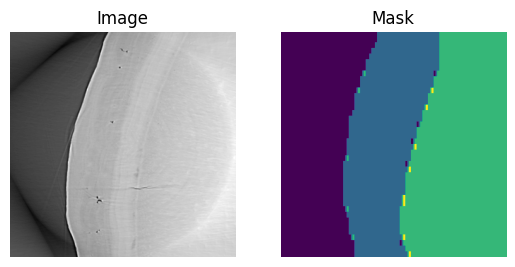

In [3]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(training_images[0], cmap="grey")
axes[1].imshow(training_masks[0])

for axis, title in zip(axes, ("Image", "Mask")):
    axis.axis("off")
    axis.set_title(title)

In [7]:
"""
Encode the labels and add this label to the data in the model; also compute class weights

The code here is a mess

"""
import warnings

from keras.utils import to_categorical
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split


def normalise_images(image: np.ndarray) -> np.ndarray:
    """
    Normalise an image or collection of images from 0-255 to 0-1

    """
    if np.issubdtype(image.dtype, np.integer):
        image = image / 255.0
    else:
        warnings.warn(f"Image is not of integer type: {image.dtype}")

    return image


def flatten_masks(masks: list) -> np.ndarray:
    """Flatten a list of masks (or images) into a single column"""
    return np.array(masks).reshape(-1, 1)


def add_axis(images: list) -> np.ndarray:
    """
    Add an axis to an image or collection of images

    """
    return np.array(images)[..., np.newaxis]


# Check that the masks only contain our required classes (and that they contain all of them - which might be unnecessary)
for i, mask in enumerate(training_masks):
    assert (
        np.unique(mask) == np.array([0, 1, 2, 3])
    ).all(), f"Mask {i} has invalid values: {np.unique(mask)}"

# Flatten the training masks into one column
train_masks_reshaped = flatten_masks(training_masks).ravel()

# Add another dimension to the training images
# This is required because the model expects images to have shape (batch_size, height, width, n_channels)
# n_channels = 1 here, becuase the images are greyscale
train_images = add_axis(training_images)
train_masks = add_axis(training_masks)

# Normalize images
train_images = normalise_images(train_images)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    train_images, train_masks, test_size=0.10, random_state=42
)

print(
    f"Class values in the dataset are ... , {dict(zip(*np.unique(y_train, return_counts=True)))}; 0 is the background/few unlabeled"
)


def reshape_and_convert_to_categorical(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Reshape the labels to match the input shape of the model and convert to categorical matrix"""
    y_cat = to_categorical(y, num_classes=num_classes)
    return y_cat.reshape((y.shape[0], y.shape[1], y.shape[2], num_classes))


# Convert the vector of labels to a one-hot encoded matrix
n_classes = len(np.unique(training_masks))
y_train_cat = reshape_and_convert_to_categorical(y_train, n_classes)

test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = reshape_and_convert_to_categorical(y_test, n_classes)

# Find class weights
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_masks_reshaped),
    y=train_masks_reshaped,
)

class_weights = dict(zip(range(n_classes), class_weights))

print("Class weights are...:", class_weights)

Class values in the dataset are ... , {0: 276856, 1: 284064, 2: 359144, 3: 1536}; 0 is the background/few unlabeled
Class weights are...: {0: 0.8270016023156045, 1: 0.8173899716467854, 2: 0.6408715853560842, 3: 142.22222222222223}


In [14]:
"""
Define the uNet

"""
from cementum import unet

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

model = unet.my_unet(
    n_classes=n_classes,
    IMG_HEIGHT=IMG_HEIGHT,
    IMG_WIDTH=IMG_WIDTH,
    IMG_CHANNELS=IMG_CHANNELS,
)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 320, 320, 16)         160       ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 320, 320, 16)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 320, 320, 16)         2320      ['dropout_18[0][0]']          
                                                                                            

In [15]:
history = model.fit(
    X_train,
    y_train_cat,
    batch_size=16,
    verbose=1,
    epochs=20,
    validation_data=(X_test, y_test_cat),
    class_weight=class_weights,
    shuffle=False,
)
model.save("cementum_test.hdf5")

Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 2.2707 - accuracy: 0.0387 - val_loss: 1.8697 - val_accuracy: 0.0076
Epoch 2/20
1/1 [==============================] - 1s 1s/step - loss: 1.6254 - accuracy: 0.0681 - val_loss: 1.6044 - val_accuracy: 0.0519
Epoch 3/20
1/1 [==============================] - 1s 1s/step - loss: 1.4368 - accuracy: 0.1012 - val_loss: 1.4497 - val_accuracy: 0.1563
Epoch 4/20
1/1 [==============================] - 1s 1s/step - loss: 1.3612 - accuracy: 0.1666 - val_loss: 1.3712 - val_accuracy: 0.1843
Epoch 5/20
1/1 [==============================] - 1s 1s/step - loss: 1.3340 - accuracy: 0.2464 - val_loss: 1.3306 - val_accuracy: 0.3184
Epoch 6/20
1/1 [==============================] - 1s 1s/step - loss: 1.3232 - accuracy: 0.3072 - val_loss: 1.3094 - val_accuracy: 0.3584
Epoch 7/20
1/1 [==============================] - 1s 1s/step - loss: 1.3174 - accuracy: 0.3380 - val_loss: 1.2964 - val_accuracy: 0.3926
Epoch 8/20
1/1 [=========================

/home/mh19137/miniforge3/envs/cementum/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


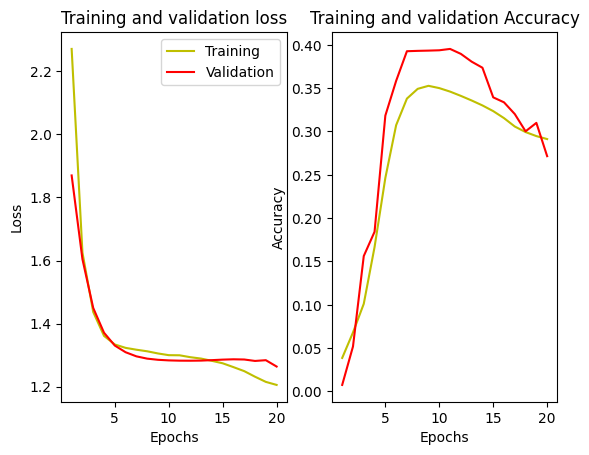

In [16]:
"""
Plot the loss and validation accuracy at each epoch

"""
loss = history.history["loss"]
val_loss = history.history["val_loss"]

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(1, len(loss) + 1)

fig, axes = plt.subplots(1, 2)
axes[0].plot(epochs, loss, "y", label="Training")
axes[0].plot(epochs, val_loss, "r", label="Validation")
axes[0].set_title("Training and validation loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")

axes[1].plot(epochs, acc, "y", label="Training")
axes[1].plot(epochs, val_acc, "r", label="Validation")
axes[1].set_title("Training and validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[0].legend()

1/1 [==============================] - 0s 149ms/step
IoU for class 0 is:  0.0608943
IoU for class 1 is:  0.14973387
IoU for class 2 is:  0.26945904
IoU for class 3 is:  0.00863117


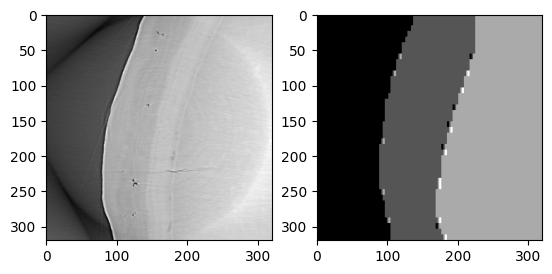

In [17]:
"""
Calculate intersection over union for each class

"""
from keras.metrics import MeanIoU

IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test[:, :, :, 0], model.predict(X_test).argmax(axis=3))


def calculate_iou(values, class_idx):
    iou = values[class_idx, class_idx] / (
        values[class_idx, :].sum()
        + values[:, class_idx].sum()
        - values[class_idx, class_idx]
    )
    return iou


values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)

for i in range(n_classes):
    class_iou = calculate_iou(values, i)
    print(f"IoU for class {i} is: ", class_iou)

fig, axes = plt.subplots(1, 2)
axes[0].imshow(train_images[0, :, :, 0], cmap="gray")
axes[1].imshow(train_masks[0], cmap="gray")

In [ ]:
""" Show the prediction for one of the training images """

(2560, 2560)


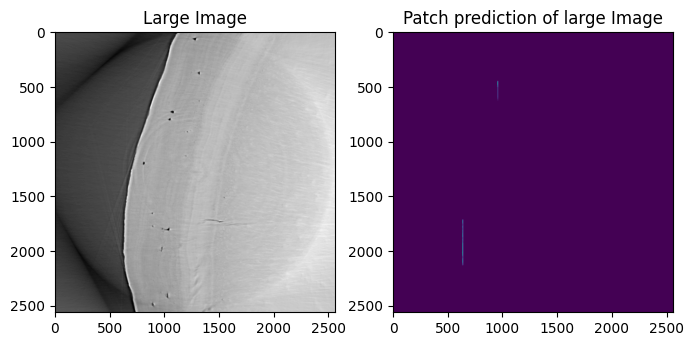

In [20]:
"""
Apply to one of the large images

"""
from patchify import patchify, unpatchify
from keras.utils import normalize

large_images = np.asarray(full_size_images)
large_image = large_images[1, :, :]
print(large_image.shape)

# This will split the image into small images of shape [3,3]
patches = patchify(
    large_image, (IMG_HEIGHT, IMG_WIDTH), step=IMG_WIDTH
)  # Step=256 for 256 patches means no overlap

predicted_patches = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        single_patch = patches[i, j, :, :]
        single_patch_norm = np.expand_dims(normalize(np.array(single_patch), axis=1), 2)
        single_patch_input = np.expand_dims(single_patch_norm, 0)
        single_patch_prediction = model.predict(single_patch_input, verbose=0)
        single_patch_predicted_img = np.argmax(single_patch_prediction, axis=3)[0, :, :]

        predicted_patches.append(single_patch_predicted_img)

predicted_patches = np.array(predicted_patches)

predicted_patches_reshaped = np.reshape(
    predicted_patches, (patches.shape[0], patches.shape[1], IMG_HEIGHT, IMG_WIDTH)
)

reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.title("Large Image")
plt.imshow(large_image, cmap="gray")
plt.subplot(222)
plt.title("Patch prediction of large Image")
plt.imshow(reconstructed_image)#, cmap="tab10")
plt.show()